# <i>COM-418 - Computers and Music</i> <br /> <br />  <b>Nonlinear processing in history - The Beatles</b> 

<div align="right">Ivor Rendulic, <a href="https://people.epfl.ch/lucie.perrotta">Lucie Perrotta</a> and <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
from scipy import signal
import import_ipynb
from Helpers import * 
from IPython.display import Audio

figsize=(10,5)
matplotlib.rcParams.update({'font.size': 16})
fs=44100;

importing Jupyter notebook from Helpers.ipynb


This notebook is a little musing inspired by the "internal mechanics" of a very famous audio snippet, namely the guitar sound at the beginning of the song "I Feel Fine", written and recorded by the Beatles in 1964. The historical significance of the record lies in the following claim by John Lennon:

> _"I defy anybody to find a record... unless it is some old blues record from 1922... that uses feedback that way. So I claim it for the Beatles. Before Hendrix, before The Who, before anybody. The first feedback on record."_

<img src="pictures/beatles.png" alt="Drawing" style="width: 50%;"/>

In this notebook, we are going to look in detail at this famous first instance of recorded guitar feedback and we will try to set up a digital model of what went down in the recording studio on that fateful 18 October 1964. In doing so we will look at a guitar simulator, at an amp model and at the mechanics of feedback. But, before anything else, let's listen to what this is all about:

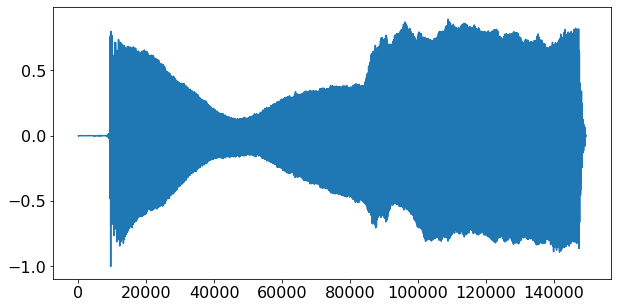

In [2]:
data = open_audio('samples/ifeelfine.wav')
Audio('samples/ifeelfine.wav', autoplay=False)

We can appreciate this behavior in the initial (non feedback) portion of the "I Feel Fine" sound snippet; let's first look at the waveform in the time domain. The "pure guitar" part is approximately from sample 10000 to sample 40000. If we plot the spectrum of this portion.

According to recording studio accounts, the sound was obtained by first playing the A string on Lennon's Gibson semiacoustic guitar and then by placing the guitar close to the amplifier. Indeed, the first two seconds of the clip sound like a standard decaying guitar tone; after that the feedback kicks in. The feedback, sometimes described as an "electric razor" buzz, is caused by two phenomena: the sound generated by the amplifier "hits" the A string and increases its vibration, and the resulting increased signal drives the amplifier into saturation.

Schematically, these are the systems involved in the generation of the opening of the song:

<img src="pictures/bd.png" alt="Drawing" style="width: 60%;"/>

In order to simulate this setup digitally, we need to come up with resonable models for:

* the guitar $G$, including the possibility of driving the string vibration during oscillation
* the amplifier $A$, including a saturating nonlinearity
* the feedback channel $F$, which will depend on the distance from the guitar to the amplifier

Let's examine each component in more detail.

## 1. Simulating a guitar

Although we have already studied the Karplus-Strong algorithm as an effective way to simulate a plucked sound, in this case we need a model that is closer to the actual physics of a guitar, since we'll need to drive the string oscillation in the feedback loop. 

In a guitar, the sound is generated by the oscillation of strings that are both under tension and fixed at both ends. Under these conditions, a displacement of the string from its rest position (i.e. the initial "plucking") will result in an oscillatory behavior in which the energy imparted by the plucking travels back and forth between the ends of the string in the form of standing waves. The natural modes of oscillation of a string are all multiples of the string's fundamental frequency, which is determined by its length, its mass and its tension (see, for instance, [here](http://www.phys.unsw.edu.au/jw/strings.html) for a detailed explanation). This image (courtesy of [Wikipedia](http://en.wikipedia.org/wiki/Vibrating_string)) shows a few oscillation modes on a string:

<center><img src="http://upload.wikimedia.org/wikipedia/commons/5/5c/Standing_waves_on_a_string.gif" width="30%"></img></center>

These vibrations are propagated to the body of an acoustic guitar and converted into sound pressure waves or, for an electric guitar, they are converted into an electrical waveform by the guitar's pickups.

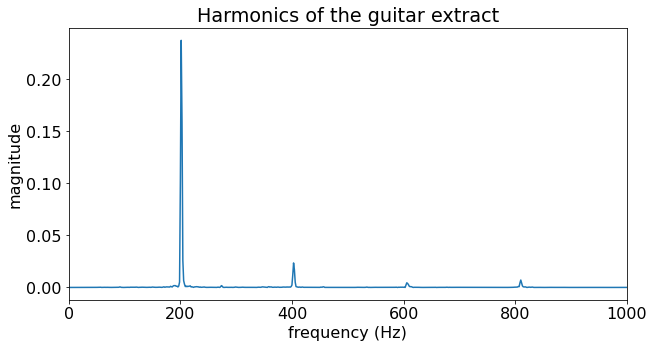

In [3]:
plt.figure(figsize=figsize)
plt.magnitude_spectrum(data[10000:40000], Fs=fs)
plt.xlim(0, 1000)
plt.xlabel("frequency (Hz)")
plt.ylabel("magnitude")
plt.title("Harmonics of the guitar extract")
plt.show()

Indeed we can see that the frequency content of the sound contains multiples of a fundamental frequency at 110Hz, which corresponds to the open A string on a standard-tuning guitar. 

From a signal processing point of view, the guitar string acts as a resonator resonating at several multiples of a fundamental frequency; this fundamental frequency determines the _pitch_ of the played note. In the digital domain, we know we can implement a resonator at a single frequency $\omega_0$ with a second-order IIR of the form 

$$
  H(z) = \frac{1}{(1 - \rho e^{j\omega_0}z^{-1})(1 - \rho e^{-j\omega_0}z^{-1})}, \quad \rho \approx 1
$$

i.e. by placing a pair of complex-conjugate poles close to the unit circle at an angle $\pm\omega_0$. A simple extension of this concept, which places poles at _all_ multiples of a fundamental frequency, is the **comb filter**. A comb filter of order $N$ has the transfer function

$$
  H(z) = \frac{1 - \rho z^{-1}}{1 - \rho^N z^{-N}}
$$

It is easy to see that the poles of the filters are at $z_k = \rho e^{j\frac{2\pi}{N}k}$, except for $k=0$ where the zero cancels the pole. For example, here is the frequency response of $H(z) = 1/(1 - (0.99)^N z^{-N})$ for $N=9$:

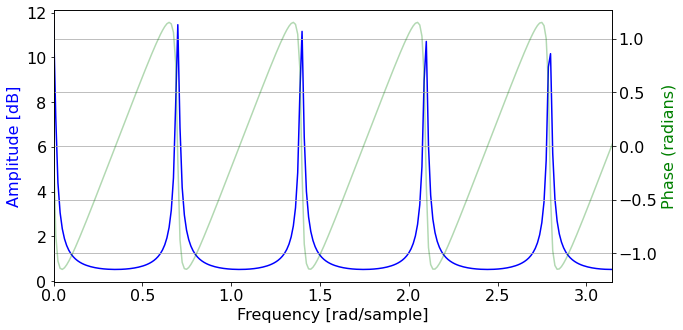

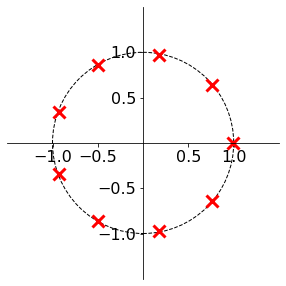

In [4]:
b = np.array([1])
a = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, -.99**9])
    
freq_response(b,a, half=True)
zplane(b,a);

An added advantage of the comb filter is that it is very easy to implement, since it requires only two multiplication per output sample _independently_ of $N$:

$$
    y[n] = \rho^N y[n-N] + x[n] - \rho x[n-1]
$$

With this, here's an idea for a guitar simulation: the string behavior is captured by a comb filter where $N$ is given by the period (in samples) of the desired fundamental frequency. Let's try it out:

In [5]:
class guitar:
    def __init__(self, pitch=110, fs=24000):
        # init the class with desired pitch and underlying sampling frequency
        self.M = int(np.round(fs / pitch)) # fundamental period in samples
        self.R = 0.9999               # decay factor
        self.RM = self.R ** self.M 
        self.ybuf = np.zeros(self.M)  # output buffer (circular)
        self.iy = 0                   # index into out buf
        self.xbuf = 0                 # input buffer (just one sample)
        
    def play(self, x):
        y = np.zeros(len(x))
        for n in range(len(x)):
            t = x[n] - self.R * self.xbuf + self.RM * self.ybuf[self.iy]
            self.ybuf[self.iy] = t
            self.iy = (self.iy + 1) % self.M
            self.xbuf = x[n]
            y[n] = t
        return y

Now we model the string plucking as a simple impulse signal in zero and we input that to the guitar model:

In [6]:
# create a 2-second signal
d = np.zeros(fs*2)
# impulse in zero (string plucked)
d[0] = 1

# create the A string
y = guitar(110, fs).play(d)
Audio(data=y, rate=fs, embed=True)

Ouch! The pitch may be right but the timbre is grotesque! The reason becomes self-evident if we look at the frequency content:

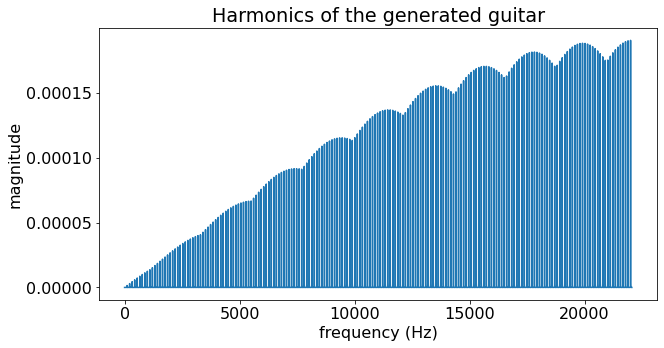

In [7]:
plt.figure(figsize=figsize)
plt.magnitude_spectrum(y, Fs=fs)
plt.xlabel("frequency (Hz)")
plt.ylabel("magnitude")
plt.title("Harmonics of the generated guitar")
plt.show()

Although we have multiples of the fundamental, we actually have _too many_ spectral lines and, because of the zero in the filter, a highpass characteristic. In a real-world guitar both the stiffness of the string and the response of the guitar's body would limit the number of harmonics to just a few, as we saw in the figure above where we analyzed the snippet from the song. 

Well, it's not too hard to get rid of unwanted spectral content: just add a lowpass filter. In this case we use a simple Butterworth that keeps only the first five harmonics:

In [8]:
class guitar:
    def __init__(self, pitch=110, fs=24000):
        # init the class with desired pitch and underlying sampling frequency
        self.M = int(np.round(fs / pitch) )# fundamental period in samples
        self.R = 0.9999               # decay factor
        self.RM = self.R ** self.M 
        self.ybuf = np.zeros(self.M)  # output buffer (circular)
        self.iy = 0                   # index into out buf
        self.xbuf = 0                 # input buffer (just one sample)
        # 6th-order Butterworth, keep 5 harmonics:
        self.bfb, self.bfa = signal.butter(6, min(0.5, 5.0 * pitch / fs))
        self.bfb *= 1000              # set a little gain 
        # initial conditions for the filter. We need this because we need to
        # filter on a sample-by-sample basis later on
        self.bfs = signal.lfiltic(self.bfb, self.bfa, [0])
        
    def play(self, x):
        y = np.zeros(len(x))
        for n in range(len(x)):
            # comb filter
            t = x[n] - self.R * self.xbuf + self.RM * self.ybuf[self.iy]
            self.ybuf[self.iy] = t
            self.iy = (self.iy + 1) % self.M
            self.xbuf = x[n]
            # lowpass filter, keep filter status for next sample
            y[n], self.bfs = signal.lfilter(self.bfb, self.bfa, [t], zi=self.bfs)
        return y

OK, let's give it a spin:

In [9]:
y = guitar(110, fs).play(d)
Audio(data=y, rate=fs, embed=True)

Ah, so much better, no? Almost like the real thing. We can check the spectrum and indeed we're close to what we wanted; the guitar is in the bag.

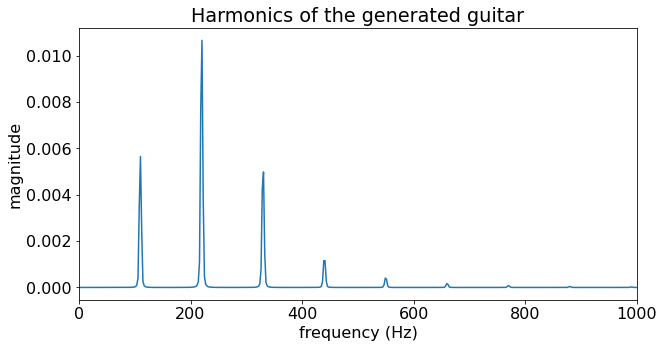

In [10]:
plt.figure(figsize=figsize)
plt.magnitude_spectrum(y[10000:30000], Fs=fs)
plt.xlim(0,1000)
plt.xlabel("frequency (Hz)")
plt.ylabel("magnitude")
plt.title("Harmonics of the generated guitar")
plt.show()
plt.show()

## 2. The amplifier

In the "I Feel Fine" setup, the volume of the amplifier remains constant; however, because of the feedback, the input will keep increasing and, at one point or another, any real-world amplifier will be driven into saturation. When that happens, the output is no longer a scaled version of the input but gets "clipped" to the maximum output level allowed by the amp. We can easily simulate this behavior with a simple memoryless clipping operatora "hard clipper" as we implemented in the Nonlinear Modelling notebook: 

In [11]:
%%capture
from NonlinearModelling import hardClipping;

We can easily check the characteristic of the amplifier simulator: 

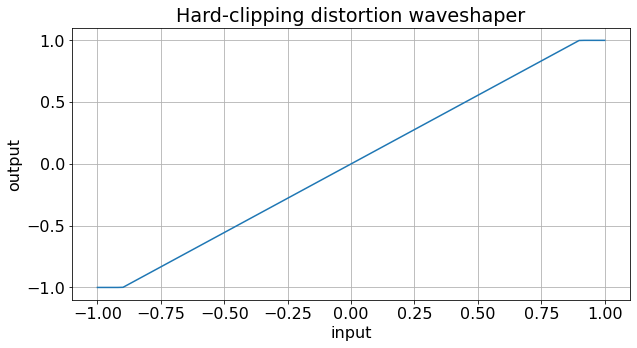

In [12]:
plt.figure(figsize=figsize)
plt.plot(np.linspace(-1, 1, 100), hardClipping(np.linspace(-1, 1, 100), 1/0.9))
plt.title("Hard-clipping distortion waveshaper")
plt.xlabel("input")
plt.ylabel("output")
plt.grid(True)
plt.show()

While the response is linear between -0.9 and +0.9, it is important to remark that the clipping introduces a nonlinearity in the processing chain. In the case of linear systems, sinusoids are eigenfunctions and therefore a linear system can only alter a sinusoid by modifying its amplitude and phase. This is not the case with nonlinear systems, which can profoundly alter the spectrum of a signal by creating new frequencies. While these effects are very difficult to analyze mathematically, from the acoustic point of view nonlinear distortion can be very interesting, and "I Feel Fine" is just one example amongst countless others. 

It is instructive at this point to look at the spectrogram (i.e. the STFT) of the sound sample (figure obtained with a commercial audio spectrum analyzer); note how, indeed, the spectral content shows many more spectral lines after the nonlinearity of the amplifier comes into play.


<img src="pictures/specgram.png" alt="Drawing" style="width: 100%;"/>

## 3. The acoustic feedback

The last piece of the processing chain is the acoustic channel that closes the feedback loop. The sound pressure waves generated by the loudspeaker of the amplifier travel through the air and eventually reach the vibrating string. For feedback to kick in, two things must happen:

* the energy transfer from the pressure wave to the vibrating string should be non-negligible
* the phase of the vibrating string must be sufficiently aligned with the phase of the sound wave in order for the sound wave to "feed" the vibration.

Sound travels in the air at about 340 meters per second and sound pressure decays with the reciprocal of the traveled distance. We can build an elementary acoustic channel simulation by neglecting everything except delay and attenuation. The output of the acoustic channel for a guitar-amplifier distance of $d$ meters will be therefore

$$
	y[n] = \alpha x[n-M]
$$

where $\alpha = 1/d$ and $M$ is the propagation delay in samples; with an internal clock of $F_s$ Hz we have $M = \lfloor d/(c F_s) \rfloor$ where $c$ is the speed of sound.

In [13]:
class feedback:
    SPEED_OF_SOUND = 343.0 # m/s
    def __init__(self, max_distance_m = 5, fs=24000):  
        # init class with maximum distance
        self.L = int(np.ceil(max_distance_m / self.SPEED_OF_SOUND * fs));
        self.xbuf = np.zeros(self.L)     # circular buffer
        self.ix = 0
        
    def get(self, x, distance):
        d = int(np.ceil(distance / self.SPEED_OF_SOUND * fs))    # delay in samples
        self.xbuf[self.ix] = x
        x = self.xbuf[(self.L + self.ix - d) % self.L]
        self.ix = (self.ix + 1) % self.L
        return x / float(distance)

## 4. Play it, Johnny

OK, we're ready to play. We will generate a few seconds of sound, one sample at a time, following these steps:

* generate a guitar sample
* process it with the nonlinear amplifier
* feed it back to the guitar via the acoustic channel using a time-varying distance

During the simulation, we will change the distance used in the feedback channel model to account for the fact that the guitar is first played at a distance from the amplifier, and then it is placed very close to it. In the first phase, the sound will simply be a decaying note and then the feedback will start moving the string back in full swing and drive the amp into saturation. We also need to introduce some coupling loss between the sound pressure waves emitted by the loudspeaker and the string, since air and wound steel have rather different impedences. 

Let's see if that works:

In [14]:
g = guitar(110)    # the A string
f = feedback()     # the feedback channel

# the "coupling loss" between air and string is high. Let's say that
#  it is about 80dBs
COUPLING_LOSS = 0.0001

# John starts 3m away and then places the guitar basically against the amp
#  after 1.5 seconds
START_DISTANCE = 3 
END_DISTANCE = 0.05

N = int(fs * 5)         # play for 5 seconds
y = np.zeros(N)     
x = [1]            # the initial plucking
# now we create each sample in a loop by processing the guitar sound
# thru the amp and then feeding back the attenuated and delayed sound
# to the guitar
for n in range(N):
    y[n] = hardClipping(g.play(x), 1/0.9)
    x = [COUPLING_LOSS * f.get(y[n], START_DISTANCE if n < (1.5 * fs) else END_DISTANCE)]
       
Audio(data=y, rate=fs, embed=True)

Pretty close, no? Of course the sound is not as rich as the original recording since

* real guitars and real amplifiers are very complex physical system with many more types of nonlinearities; amongst others:
  * the spectral content generated by the string varies with the amplitude of its oscillation
  * the spectrum of the generated sound is not perfectly harmonic due to the physical size of the string
  * the string may start touching the frets when driven into large oscillations
  * the loudspeaker may introduce additional frequencies if driven too hard
  * ...
* we have neglected the full frequency response of the amp both in linear and in nonlinear mode
* it's the BEATLES, man! How can DSP compete?

Well, hope this was a fun and instructive foray into music and signal processing. You can now play with the parameters of the simulation and try to find alternative setups: 

* try to change the characteristic of the amp, maybe using a sigmoid (hyperbolic tangent)
* change the gain, the coupling loss or the frequency of the guitar
* change John's guitar's position and verify that feedback does not occur at all distances.